In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from termcolor import colored
from statsmodels.tsa.deterministic import DeterministicProcess
import datetime
from matplotlib.ticker import MaxNLocator

In [2]:
vib1 = pd.read_pickle("HYDRO_M2_BN_TGB_X_DA.pkl") # Turbine bearing vibration x
pwr = pd.read_pickle("HYDRO_M2-DPM-GEN-MW.pkl") # power output
vib1 = vib1[~vib1.index.duplicated(keep='first')]
pwr = pwr[~pwr.index.duplicated(keep='first')]

all_vars = [vib1, pwr]
df = pd.concat(all_vars, axis=1)
print('shape of df: ', df.shape)
df.head(3)


shape of df:  (9465913, 2)


,HYDRO_M2_BN_TGB_X_DA.MC@MF,HYDRO_M2-DPM-GEN-MW.MC@MF
2020-10-18 00:00:00,0.017166,-0.035158
2020-10-18 00:00:10,0.017166,-0.035158
2020-10-18 00:00:20,0.017166,-0.035158


In [3]:
# vib1 = pd.read_pickle("HYDRO_M2_BN_TGB_X_DA.pkl") # Turbine bearing vibration x
# vib3 = pd.read_pickle("HYDRO_M2_BN_GGB_X_DA.pkl") # Guide bearing vibration x
# pwr = pd.read_pickle("HYDRO_M2-DPM-GEN-MW.pkl") # power output
# vib1 = vib1[~vib1.index.duplicated(keep='first')]
# vib3 = vib3[~vib3.index.duplicated(keep='first')]
# pwr = pwr[~pwr.index.duplicated(keep='first')]

# all_vars = [vib1, vib3, pwr]
# df = pd.concat(all_vars, axis=1)
# print('shape of df: ', df.shape)
# df.head(3)


In [4]:
df.isna().sum()

#df.dropna(inplace = True)
#print(len(df))

HYDRO_M2_BN_TGB_X_DA.MC@MF    372829
HYDRO_M2-DPM-GEN-MW.MC@MF          0
dtype: int64

In [5]:
#df = df.to_period(freq = '10s')

In [6]:
# feature engineering - date time
time_features = ['year', 'month', 'day', 'hour', 'minute', 'second', 'dayofyear', 'dayofweek','quarter']
for f in time_features:
    df[f] = getattr(df.index, f)

df['week'] = np.ceil(df['dayofyear'] / 7).astype(int)
df.head(3)

,HYDRO_M2_BN_TGB_X_DA.MC@MF,HYDRO_M2-DPM-GEN-MW.MC@MF,year,month,day,hour,minute,second,dayofyear,dayofweek,quarter,week
2020-10-18 00:00:00,0.017166,-0.035158,2020,10,18,0,0,0,292,6,4,42
2020-10-18 00:00:10,0.017166,-0.035158,2020,10,18,0,0,10,292,6,4,42
2020-10-18 00:00:20,0.017166,-0.035158,2020,10,18,0,0,20,292,6,4,42


In [7]:
gen_df = df[df['HYDRO_M2-DPM-GEN-MW.MC@MF'] > 15].copy()
print(len(gen_df))
gen_df.head()

1390828


,HYDRO_M2_BN_TGB_X_DA.MC@MF,HYDRO_M2-DPM-GEN-MW.MC@MF,year,month,day,hour,minute,second,dayofyear,dayofweek,quarter,week
2020-11-09 14:22:00,3.882614,41.815880,2020,11,9,14,22,0,314,0,4,45
2020-11-09 14:22:10,1.926451,50.569092,2020,11,9,14,22,10,314,0,4,45
2020-11-09 14:22:20,1.971132,50.102951,2020,11,9,14,22,20,314,0,4,45
2020-11-09 14:22:30,1.922760,50.270050,2020,11,9,14,22,30,314,0,4,45
2020-11-09 14:22:40,1.977975,50.047852,2020,11,9,14,22,40,314,0,4,45


#### Total Electricity demand vs Avg vibration

In [8]:
mysettings = {
    'Monthly': ['year', 'month'],
    'Weekly': ['year', 'week'],
    'Daily': ['year', 'dayofyear'],
}

35


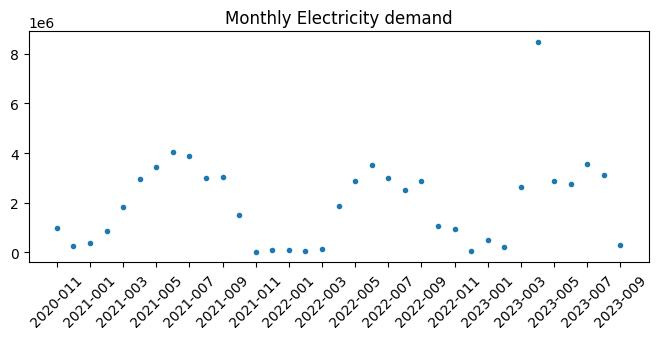

35


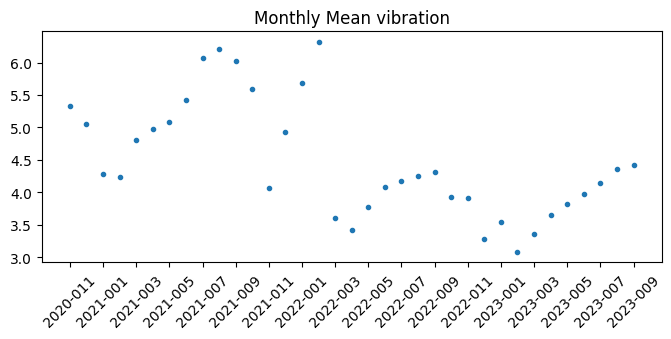

35 HYDRO_M2-DPM-GEN-MW.MC@MF     0
HYDRO_M2_BN_TGB_X_DA.MC@MF    0
dtype: int64


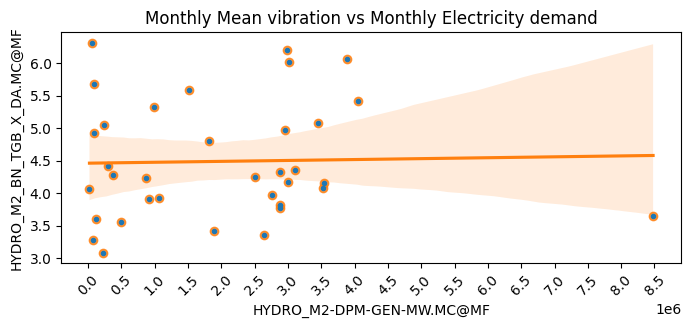

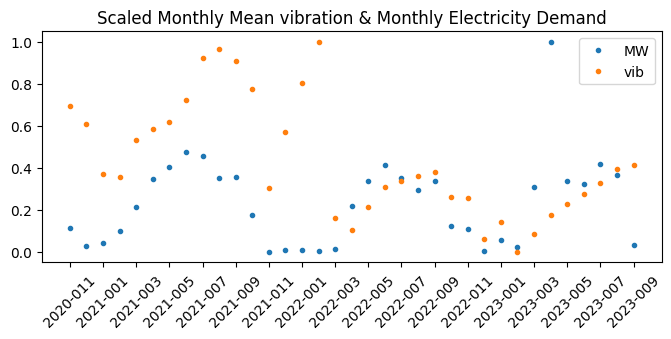

133


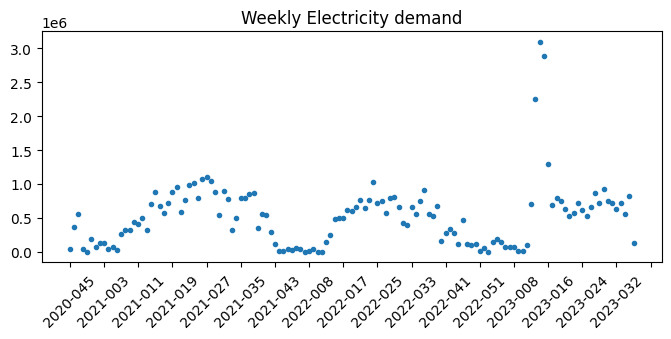

133


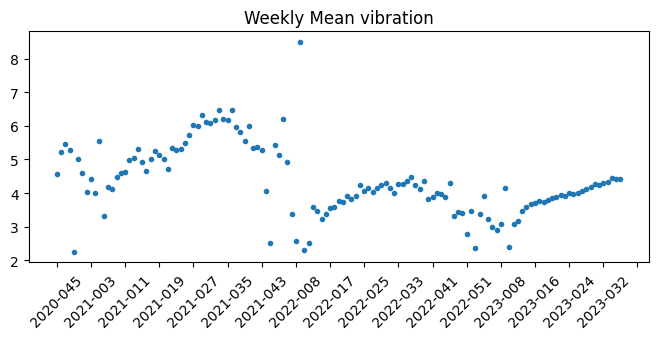

133 HYDRO_M2-DPM-GEN-MW.MC@MF     0
HYDRO_M2_BN_TGB_X_DA.MC@MF    0
dtype: int64


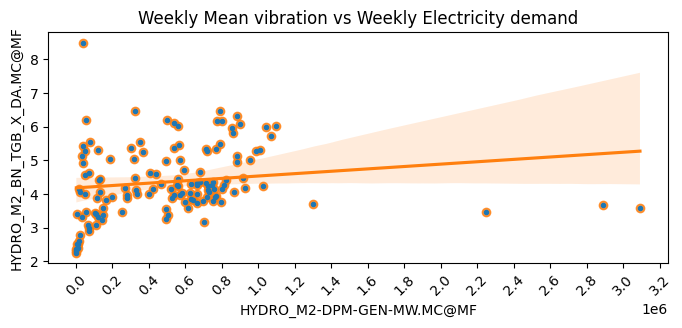

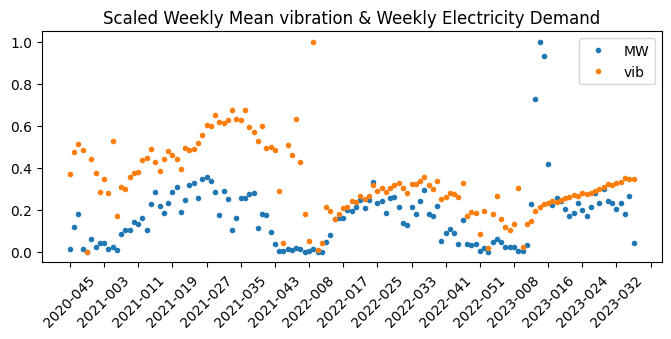

697


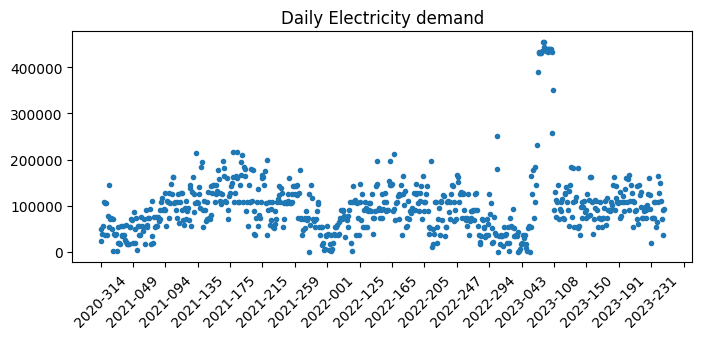

697


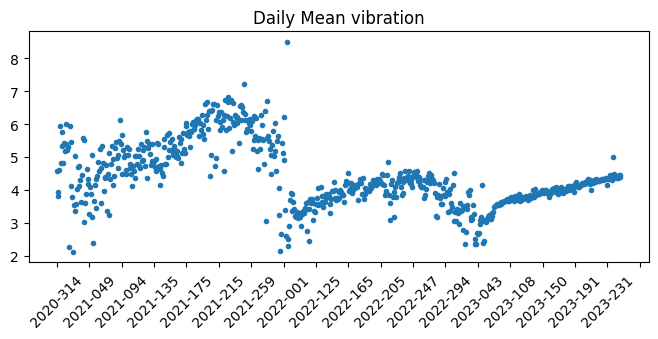

697 HYDRO_M2-DPM-GEN-MW.MC@MF     0
HYDRO_M2_BN_TGB_X_DA.MC@MF    0
dtype: int64


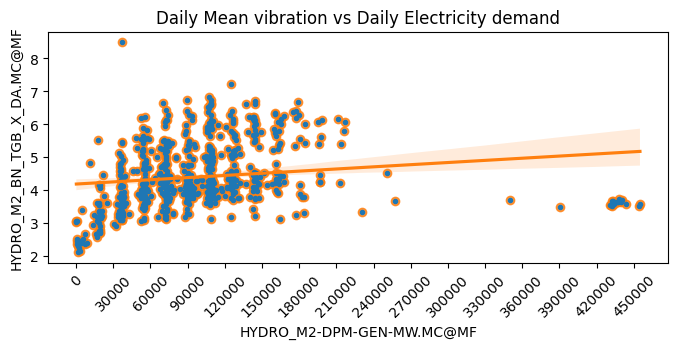

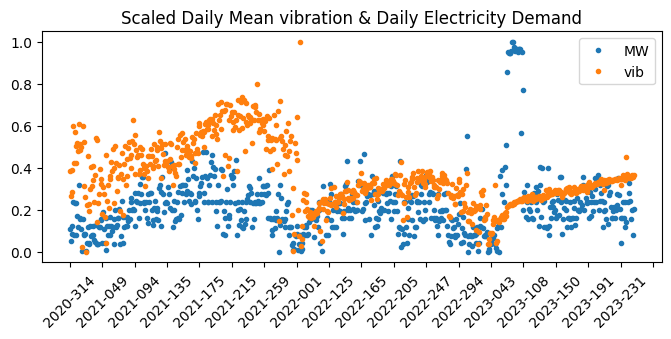

In [38]:
for name, group_vars in mysettings.items():

    ###########################
    ### Elec demand ##########
    ##########################
    elec_demand = gen_df.groupby(group_vars).sum()[["HYDRO_M2-DPM-GEN-MW.MC@MF"]]
    print(len(elec_demand))
    elec_demand.index = elec_demand.index.map(lambda x: f"{x[0]}-{x[1]:03d}")
    elec_demand.head()
    
    fig, ax = plt.subplots(figsize = (8,3))
    ax.plot(elec_demand.index, elec_demand["HYDRO_M2-DPM-GEN-MW.MC@MF"], '.')
    ax.tick_params(axis="x", rotation = 45)
    ax.set_title(f'{name} Electricity demand')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
    plt.show()
    
    ###########################
    ### Vibration ##########
    ##########################
    data = gen_df.copy()
    mean_vib = data.groupby(group_vars).mean()[["HYDRO_M2_BN_TGB_X_DA.MC@MF"]]
    print(len(mean_vib))
    mean_vib.index = mean_vib.index.map(lambda x: f"{x[0]}-{x[1]:03d}")
    mean_vib.head()
    
    fig, ax = plt.subplots(figsize = (8,3))
    ax.plot(mean_vib.index, mean_vib["HYDRO_M2_BN_TGB_X_DA.MC@MF"], '.')
    ax.tick_params(axis="x", rotation = 45)
    ax.set_title(f'{name} Mean vibration')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
    plt.show()
    
    ######################################
    #### Scatter plot - Elec vs Vib #####
    ######################################
    combined_df = elec_demand.join(mean_vib, how='outer') # NAN can be problematic
    print(len(combined_df), combined_df.isna().sum())
    #combined_df.dropna(inplace=True) 
    
    fig, ax = plt.subplots(figsize = (8,3))
    ax.plot(combined_df["HYDRO_M2-DPM-GEN-MW.MC@MF"], combined_df["HYDRO_M2_BN_TGB_X_DA.MC@MF"], '.')
    ax.tick_params(axis="x", rotation = 45)
    ax.set_title(f'{name} Mean vibration vs {name} Electricity demand')
    ax = sns.regplot(x=combined_df["HYDRO_M2-DPM-GEN-MW.MC@MF"], y=combined_df["HYDRO_M2_BN_TGB_X_DA.MC@MF"])
    ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
    plt.show()
    
    ############################################
    #### Plot Overlay to check correlation #####
    ############################################
    scaled_df = combined_df.copy()
    scaled_df = (scaled_df - scaled_df.min())/(scaled_df.max() - scaled_df.min())
    #scaled_df = (scaled_df)/(scaled_df.max())
    scaled_df
    
    
    fig, ax = plt.subplots(figsize = (8,3))
    ax.plot(scaled_df.index, scaled_df["HYDRO_M2-DPM-GEN-MW.MC@MF"], '.', label = 'MW')
    ax.plot(scaled_df.index,scaled_df["HYDRO_M2_BN_TGB_X_DA.MC@MF"] , '.', label = 'vib')
    ax.tick_params(axis="x", rotation = 45)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax.set_title(f'Scaled {name} Mean vibration & {name} Electricity Demand')
    ax.legend()
    plt.show()

In [31]:
# plt.figure(figsize = (15,3))
# plt.scatter(combined_df.index, combined_df['HYDRO_M2_BN_TGB_X_DA.MC@MF'])

In [32]:
# plt.scatter(scaled_df.index, scaled_df['HYDRO_M2_BN_TGB_X_DA.MC@MF'])

In [33]:
mean_vib

,HYDRO_M2_BN_TGB_X_DA.MC@MF
2020-011,5.332729
2020-012,5.057926
2021-001,4.277717
2021-002,4.228154
2021-003,4.810194
2021-004,4.977471
2021-005,5.087580
2021-006,5.425548
2021-007,6.071739
2021-008,6.214438


In [34]:
combined_df

,HYDRO_M2-DPM-GEN-MW.MC@MF,HYDRO_M2_BN_TGB_X_DA.MC@MF
2020-011,9.813852e+05,5.332729
2020-012,2.359542e+05,5.057926
2021-001,3.774148e+05,4.277717
2021-002,8.743669e+05,4.228154
2021-003,1.813103e+06,4.810194
2021-004,2.953231e+06,4.977471
2021-005,3.453718e+06,5.087580
2021-006,4.043944e+06,5.425548
2021-007,3.883898e+06,6.071739
2021-008,2.978785e+06,6.214438


In [25]:
df2 = combined_df.sort_index()
df2

,HYDRO_M2-DPM-GEN-MW.MC@MF,HYDRO_M2_BN_TGB_X_DA.MC@MF
2020-11,9.813852e+05,5.332729
2020-12,2.359542e+05,5.057926
2021-1,3.774148e+05,4.277717
2021-10,1.520118e+06,5.587617
2021-11,1.945760e+04,4.069374
2021-12,8.196712e+04,4.927465
2021-2,8.743669e+05,4.228154
2021-3,1.813103e+06,4.810194
2021-4,2.953231e+06,4.977471
2021-5,3.453718e+06,5.087580


In [29]:
elec_demand

,HYDRO_M2-DPM-GEN-MW.MC@MF
2020-011,9.813852e+05
2020-012,2.359542e+05
2021-001,3.774148e+05
2021-002,8.743669e+05
2021-003,1.813103e+06
2021-004,2.953231e+06
2021-005,3.453718e+06
2021-006,4.043944e+06
2021-007,3.883898e+06
2021-008,2.978785e+06


Seems there is a seasonal demand of electricity. Let us see for vibration